           Date      Id  Nominal    Value
0    01.01.2021  R01235        1  73.8757
1    12.01.2021  R01235        1  74.5157
2    13.01.2021  R01235        1  74.2663
3    14.01.2021  R01235        1  73.5264
4    15.01.2021  R01235        1  73.7961
..          ...     ...      ...      ...
253  18.01.2022  R01235        1  76.0404
254  19.01.2022  R01235        1  76.3347
255  20.01.2022  R01235        1  76.8697
256  21.01.2022  R01235        1  76.4408
257  22.01.2022  R01235        1  76.6903

[258 rows x 4 columns]


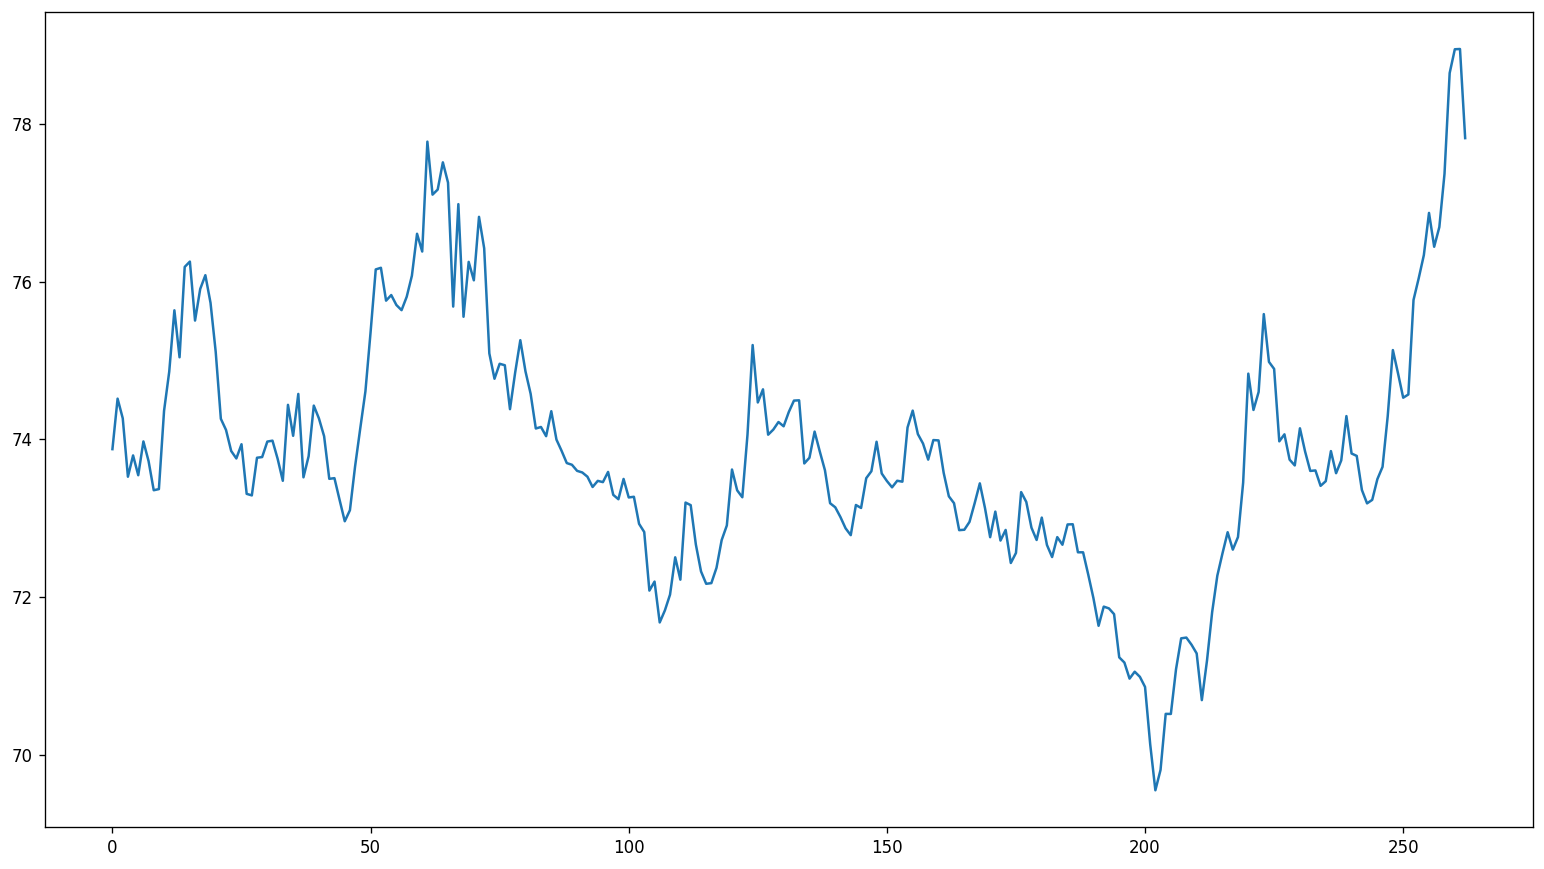

In [136]:
from pandas.io.formats.format import decimal
import pandas as pd
import warnings

# Игнорирование ошибок при построении ARIMA модели
warnings.simplefilter(action='ignore', category=FutureWarning)

# Получение данных с цб при помощи XML
data_start = '01/01/2021'
data_end = '31/01/2022'
VAL = 'R01235'
url = 'https://www.cbr.ru/scripts/XML_dynamic.asp?date_req1={}&date_req2={}&VAL_NM_RQ={}'.format(data_start, data_end, VAL)
data = pd.read_xml(url)
data['Value'] = [float(x.replace(',', '.')) for x in data['Value']]

print(data.head(-5))

data['Value'].plot()

In [137]:
# Вывод основных метрик по Value
metric_data = data.Value.describe()
metric_data.loc['median'] = [data.Value.median()] 
metric_data

count         263.0
mean      73.835433
std        1.563122
min         69.5526
25%        72.95785
50%         73.6694
75%         74.5052
max          78.947
median    [73.6694]
Name: Value, dtype: object

In [138]:
# Тест Аадфулера
from statsmodels.tsa.stattools import adfuller 

res = adfuller( data.Value.dropna()) 
print('Augmented Dickey-Fuller Statistic: %f' % res[0]) 
print('p-value: %f' % res[1]) 


Augmented Dickey-Fuller Statistic: -1.746957
p-value: 0.407096


(249, 4) (14, 4) (263, 4)


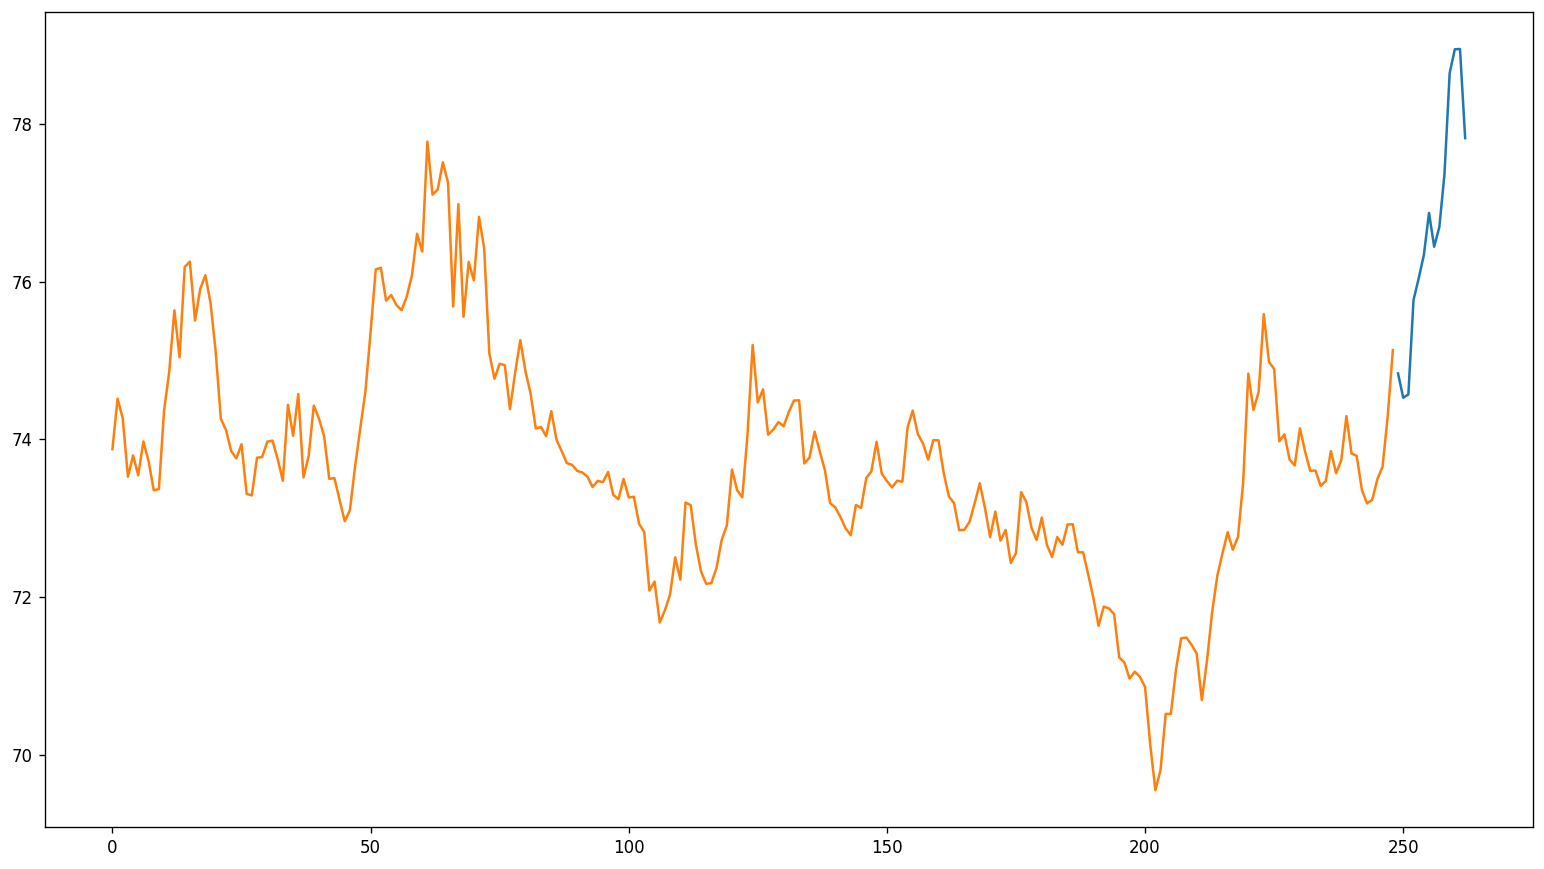

In [139]:
# Разбиение на обучающую и тестовую выборки

p = 0.95
train_data = data[:int(p*len(data))]
test_data = data.drop(train_data.index)

print(train_data.shape, test_data.shape, data.shape)
test_data.head()

test_data.Value.plot()
train_data.Value.plot()

In [140]:
# Подбор параметров AR и MA

import statsmodels.api as sm

sm.tsa.arma_order_select_ic(train_data.Value , max_ar=4, max_ma=3, ic='aic')

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


{'aic':             0           1           2           3
 0  878.715011  655.773910  519.317221  460.136754
 1  312.066743  313.222516  313.672345  315.612393
 2  313.076162  312.760520  315.442510  317.441681
 3  313.505575  315.389026  318.218911  319.622181
 4  315.492917  316.565916  317.893133  319.870272, 'aic_min_order': (1, 0)}

In [141]:
# Построение модели ARIMA

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

model = ARIMA(train_data.Value, order=(1, 0, 0))
model_fit_arima = model.fit(disp=0)
print(model_fit_arima.summary2())


                          Results: ARMA
Model:              ARMA             BIC:                 322.6191
Dependent Variable: Value            Log-Likelihood:      -153.03 
Date:               2022-11-03 13:34 Scale:               1.0000  
No. Observations:   249              Method:              css-mle 
Df Model:           2                Sample:              0       
Df Residuals:       247                                   9       
Converged:          1.0000           S.D. of innovations: 0.445   
No. Iterations:     6.0000           HQIC:                316.314 
AIC:                312.0667                                      
-------------------------------------------------------------------
               Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const         73.7777    0.4954  148.9388  0.0000  72.8068  74.7486
ar.L1.Value    0.9466    0.0195   48.5553  0.0000   0.9083   0.9848
-----------------

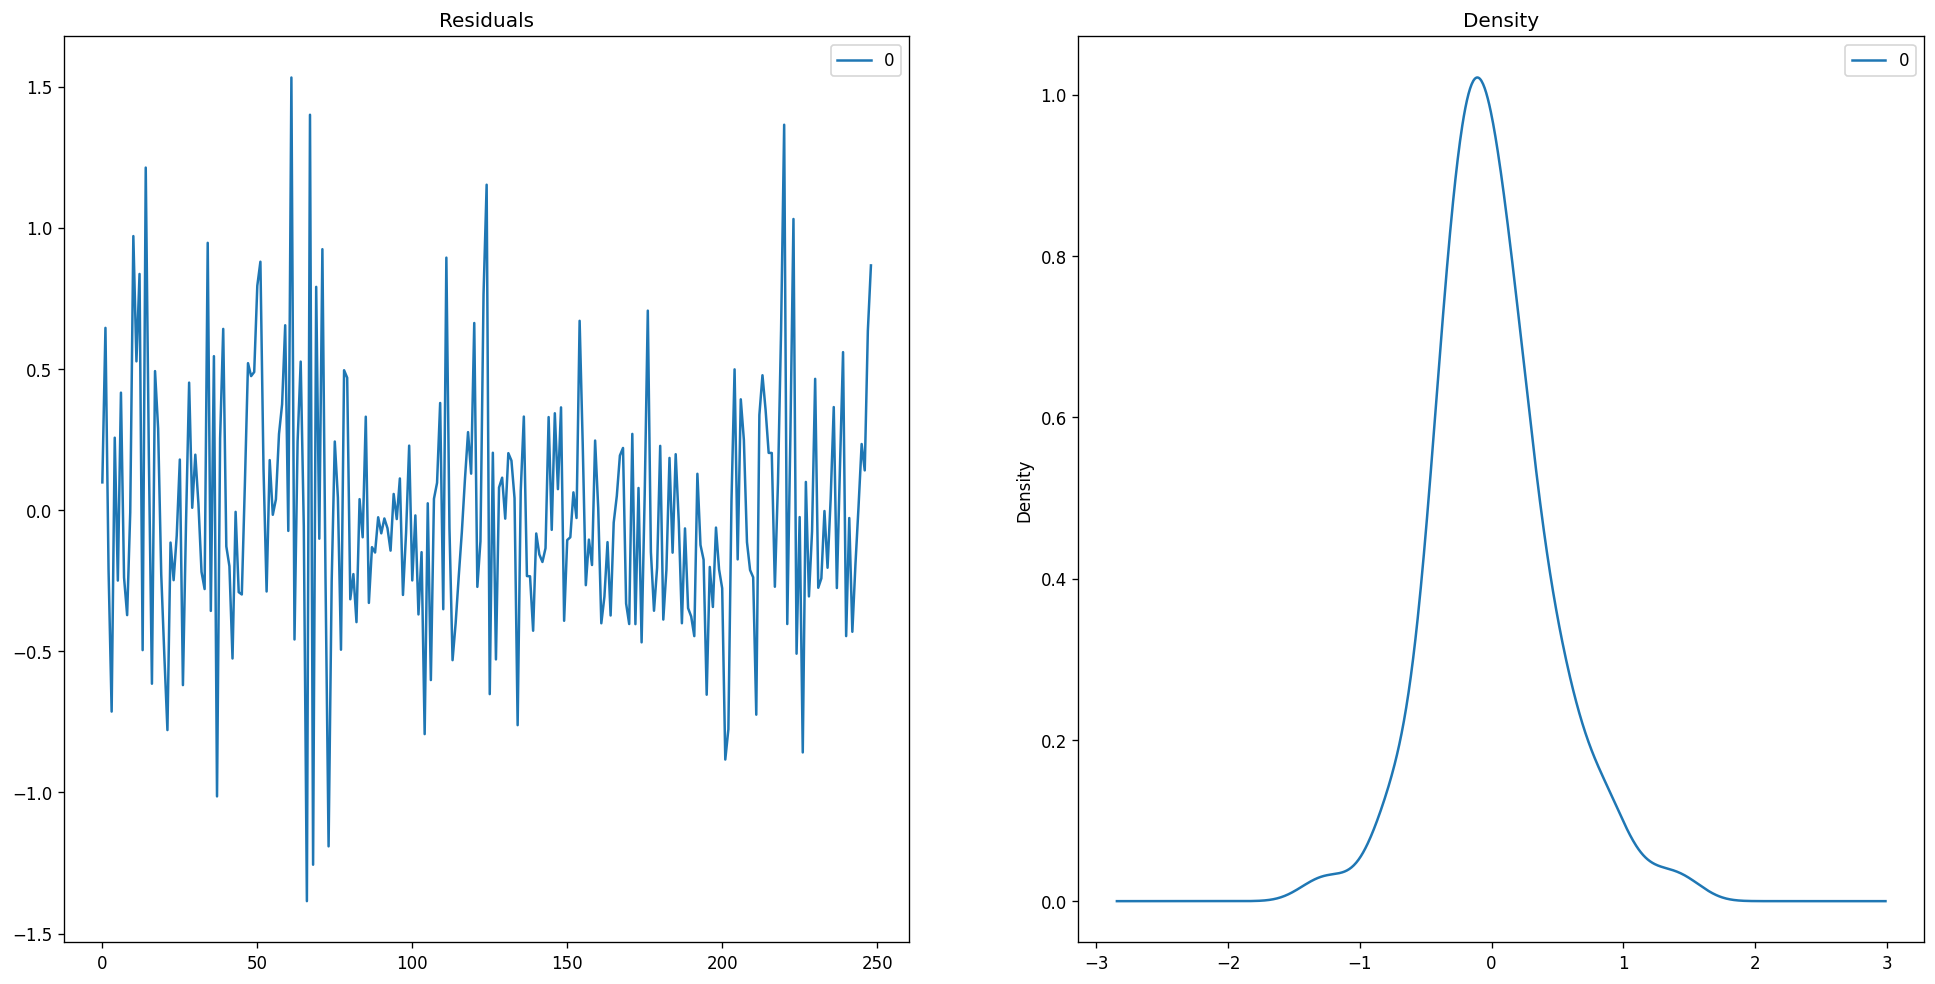

In [142]:
# Проверка остатков

myresiduals = pd.DataFrame(model_fit_arima.resid) 
fig, ax = plt.subplots(1,2, figsize=(20, 10)) 
myresiduals.plot(title = "Residuals", ax = ax[0]) 
myresiduals.plot(kind = 'kde', title = 'Density', ax = ax[1]) 
plt.show()

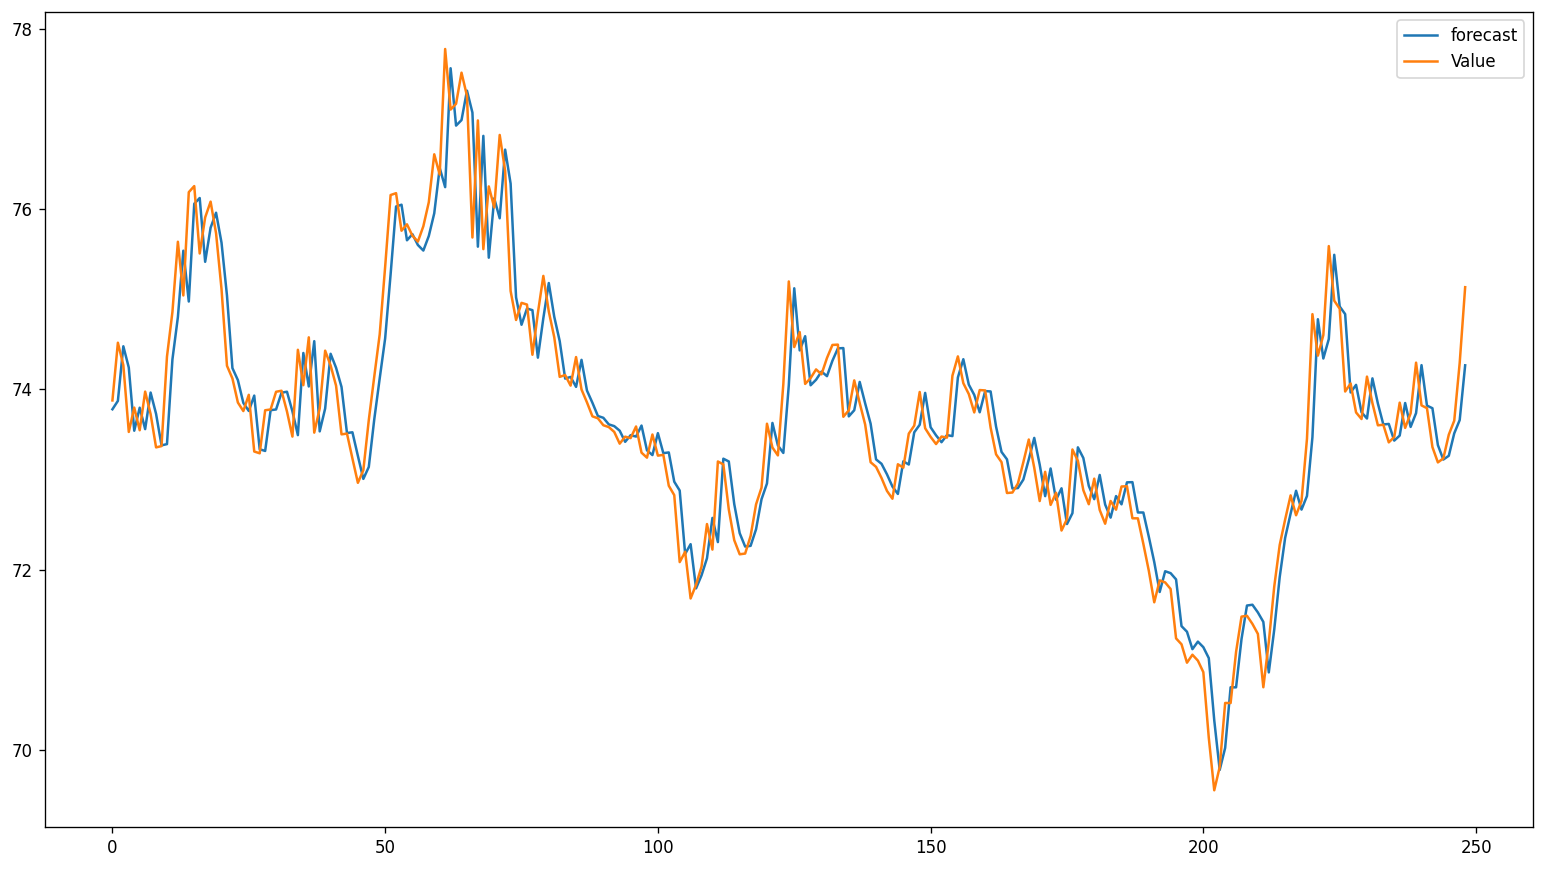

In [143]:
# Обучающая выборка и построенная модель

plt.rcParams.update({'figure.figsize' :(16,9), 'figure.dpi' : 120}) 

model_fit_arima.plot_predict(dynamic = False) 

plt.show() 



In [152]:
# Построение предикта на основе обучающей выборки
pred = model_fit_arima.forecast(steps=len(test_data))[0]
print(pred)

[75.05914999 74.99066648 74.92584284 74.86448349 74.80640328 74.75142697
 74.69938868 74.65013141 74.60350652 74.55937335 74.51759872 74.4780566
 74.44062768 74.40519901]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 0, 'Date')

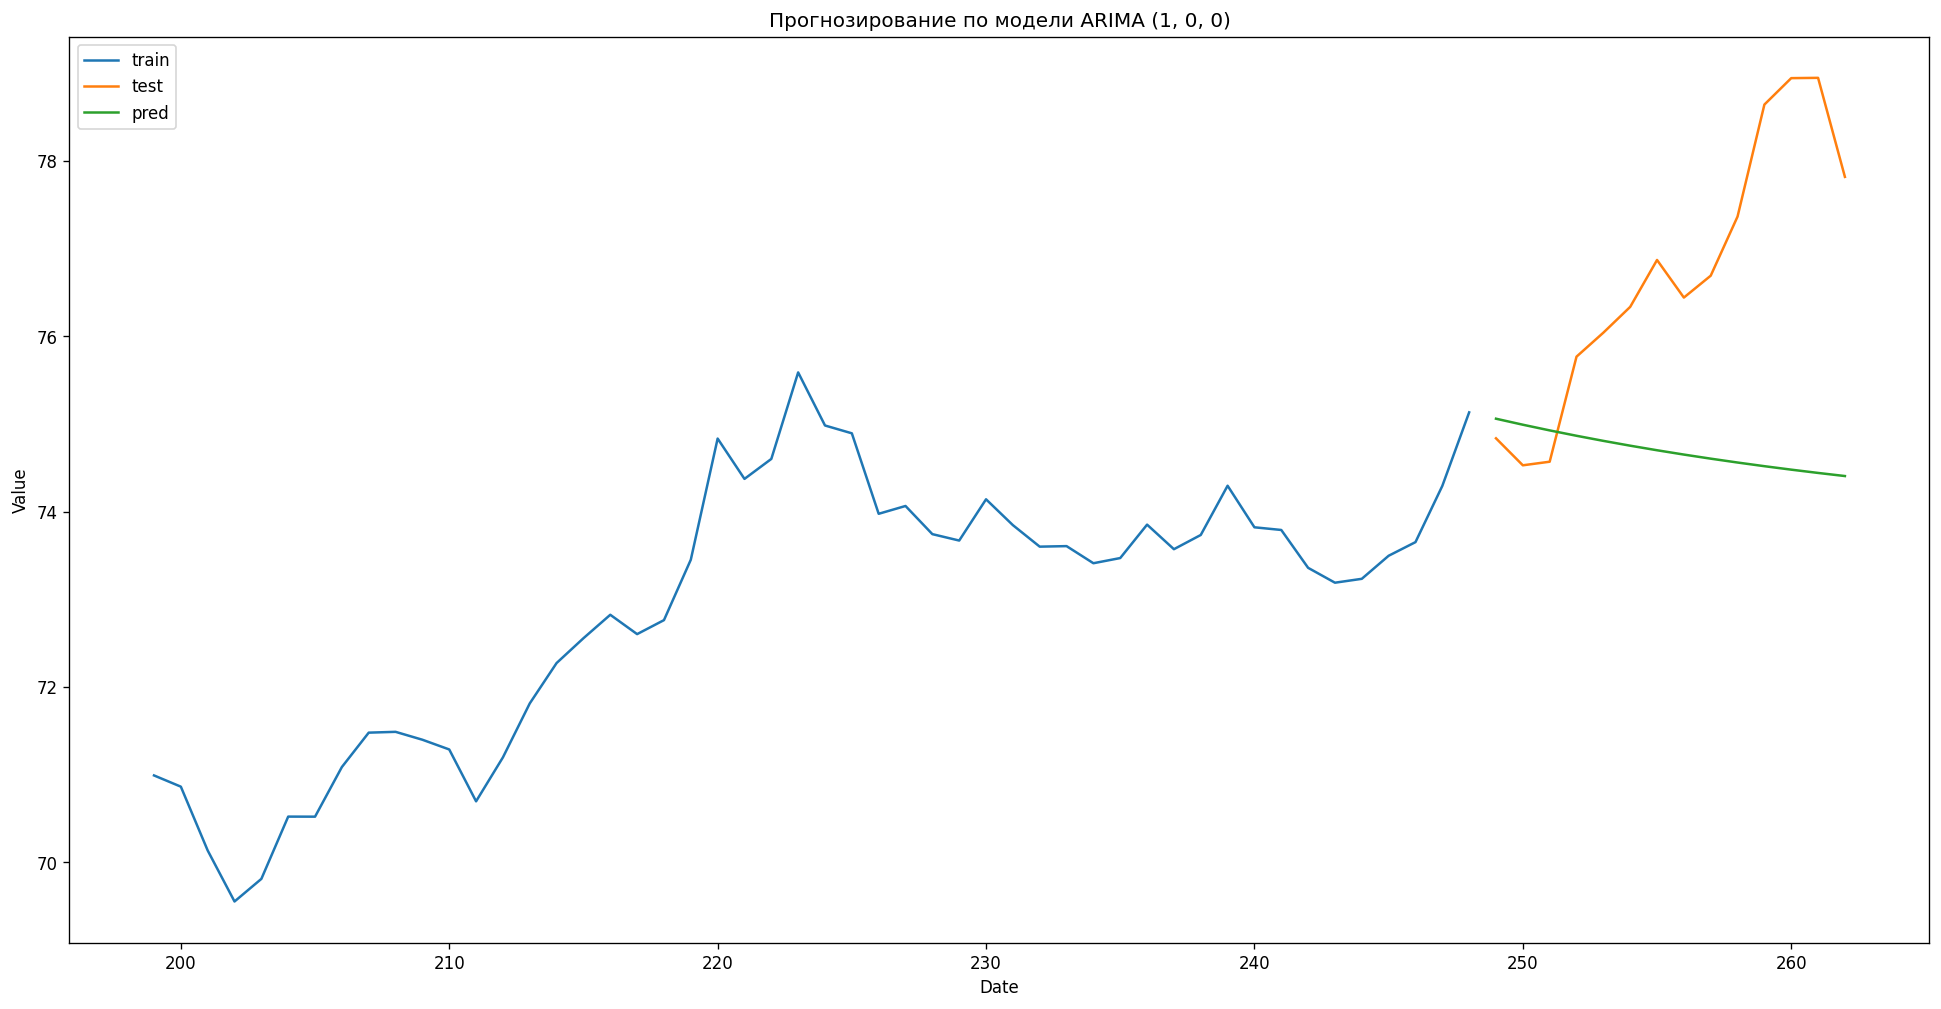

In [153]:
# Графическое отображение предсказаний модели ARIMA

import matplotlib.pyplot as plt
plt_data = data[len(train_data):]
data.iloc[len(train_data)]
plt_data['Value'] = pred

figl, ax = plt.subplots(figsize=(20, 10))
ax.plot(train_data.Value[-50:], label='train')
ax.plot(test_data.Value, label='test')
ax.plot(plt_data.Value, label='pred')
plt.legend(loc='upper left')
plt.title('Прогнозирование по модели ARIMA (1, 0, 0)')
plt.ylabel('Value')
plt.xlabel('Date')

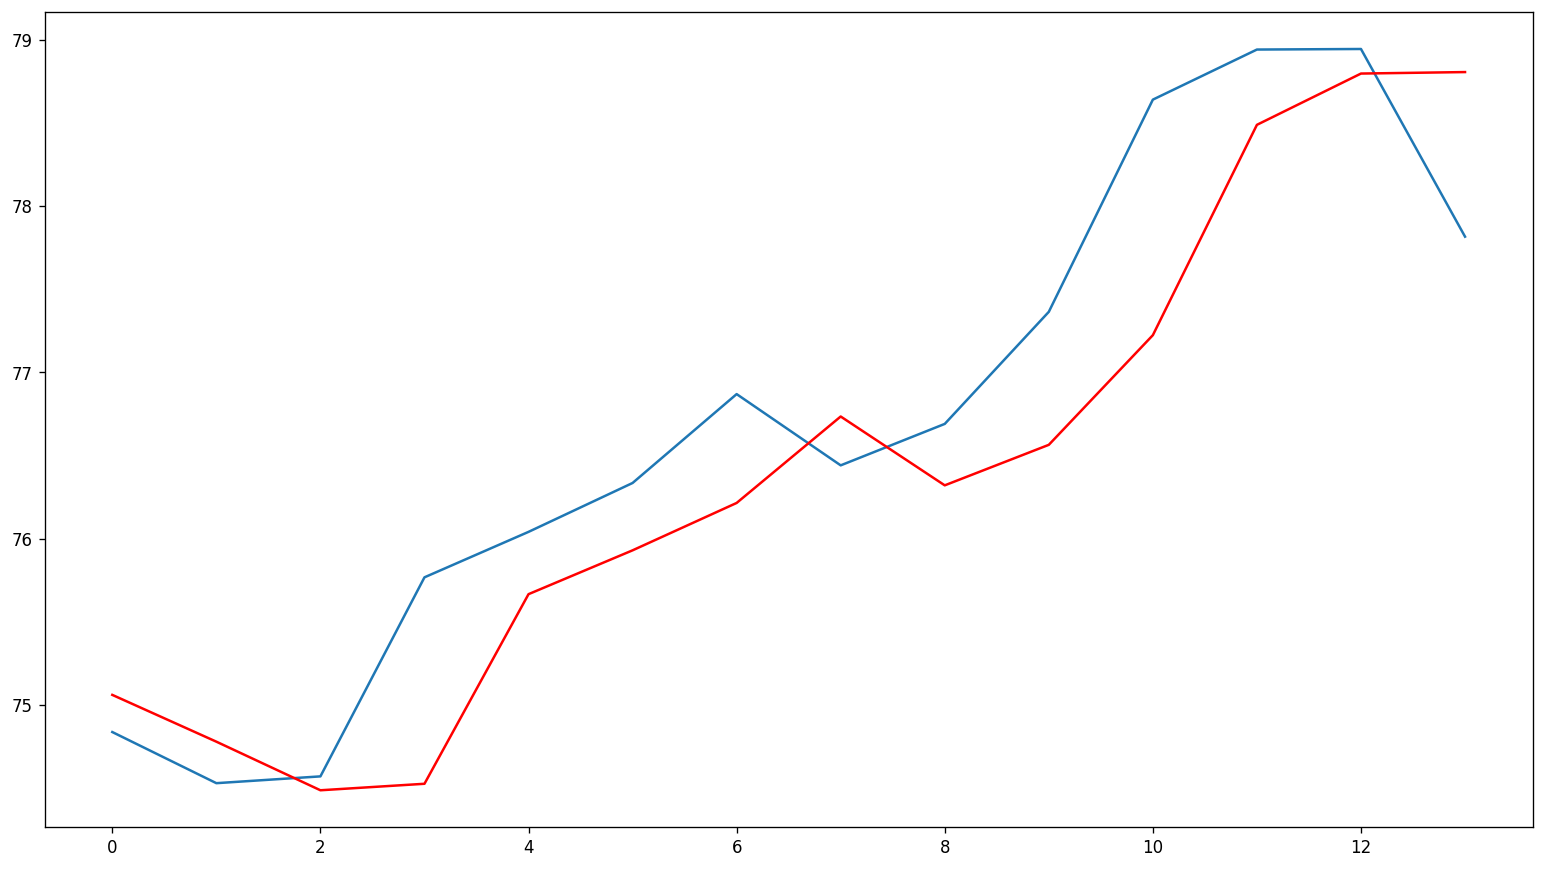

In [154]:
# Осуществление предсказания курса валют на каждый шаг, с учётом добавления предсказанного значения в history


history = train_data.Value.copy()
predictions = list()


for t in range(len(test_data)):
  model = ARIMA(history, order=(1,0,0))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test_data.Value.iloc[t]
  history.loc[ len(history.index )] = obs
error = mean_squared_error(test_data.Value, predictions)

test = test_data.Value.copy()
test.reset_index(drop= True , inplace= True )

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()